In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

### Read dataframe

In [2]:
from config import DF_TRAIN

In [3]:
df = pd.read_csv(DF_TRAIN)

### Dataset anaslysis

In [4]:
df.head(10)

,id,comment_text,Toxic
0,0028d62e8a5629aa,All of my edits are good. Cunts like you who ...,Toxic
1,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,Toxic
2,00b77cb600c897b4,"""\n\nAnd you are? Let me know when you've craw...",Toxic
3,00c0b8ed05ed7833,Fuck off\n\nYou are NOT an administrator. You ...,Toxic
4,00d7a73eb033ee5e,"Have you seen the reference to their claim, yo...",Toxic
5,011d0c0a6c8e5765,I NEVER FUCKING MADE THIS MOTHER FUCKING ARTIC...,Toxic
6,0122aba9f97885cd,There are many broken nostrils in this pancreas,Non-Toxic
7,016aa1af4fa90e8b,"""\n\nElvis... Crying in the Chapel Feudalist """,Non-Toxic
8,019ab9a91e7fcdbe,Are you fucker mother fucker have nothing to d...,Toxic
9,01ce75675a501e50,"""\\nYou wasted your own time! Take this advice...",Toxic


In [5]:
df.describe()

,id,comment_text,Toxic
count,2000,2000,2000
unique,2000,2000,2
top,0028d62e8a5629aa,All of my edits are good. Cunts like you who ...,Toxic
freq,1,1,1500


In [6]:
example = 9
print('Comment')
print('------------------------------')
print(df['comment_text'][example])
print('------------------------------')
print(df['Toxic'][example])

Comment
------------------------------
"\
You wasted your own time! Take this advice with you: Pull your head out of your ass! Be real and don't spend the rest of your life sucking ass. Have a nice life! Goodbye!  (mailbox) "
------------------------------
Toxic


After analyzing the data, an X_CHANGE_WORDS constant was created in the config.py file referring to the words in the text that could be modified to improve the classifiers.

### Preprocessing

In [7]:
from nlp_preprocessing import basic_preprocessing, lemmatizer, change_words, y_encoder
from sklearn.model_selection import train_test_split
from config import Y_CHANGE_WORDS, X_CHANGE_WORDS

[nltk_data] Downloading package words to /home/geovane/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/geovane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/geovane/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/geovane/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


All the functions of the nlp_training, nlp_preprocessing and ml_training files are mine

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'], df['Toxic'], test_size=0.33, shuffle=True)

In [9]:
y_train, y_test = y_encoder(y_train, Y_CHANGE_WORDS), y_encoder(y_test, Y_CHANGE_WORDS)

This Y_CHANGE_WORDS constant defined in config.py is intended to standardize the transformation of categorical data into numeric data.

In [10]:
X_train, X_test = basic_preprocessing(change_words(X_train, X_CHANGE_WORDS)), basic_preprocessing(change_words(X_test, X_CHANGE_WORDS))

In [11]:
preprocessed_data = [('Basic', X_train, X_test),('& Lematizer', lemmatizer(X_train),lemmatizer(X_test))]

This array is defined in order to test classifiers with different processing steps

### Basic training

In [12]:
from nlp_training import simple_training
from config import MODELS, METHODS, METRICS

In [13]:
dataframe = pd.DataFrame({})
for method in METHODS:
    for name, X_train, X_test in preprocessed_data: 
        aux = simple_training(X_train, y_train, X_test, y_test, MODELS, METRICS, method)
        aux['Preprocessing'] = name
        aux['Method'] = method
        dataframe = pd.concat([dataframe, aux], ignore_index=True)

In [14]:
dataframe.sort_values(by=['accuracy_score'], ascending=[False]).head()

,Model,accuracy_score,f1_score,precision_score,Preprocessing,Method
16,MLP_2_layer,0.846970,0.901846,0.862454,& Lematizer,TfidfVectorizer()
38,MLP_2_layer,0.845455,0.899010,0.874759,& Lematizer,CountVectorizer()
27,MLP_2_layer,0.845455,0.897590,0.885149,Basic,CountVectorizer()
5,MLP_2_layer,0.840909,0.897160,0.864151,Basic,TfidfVectorizer()
4,MLP_1_layer,0.839394,0.896078,0.863894,Basic,TfidfVectorizer()


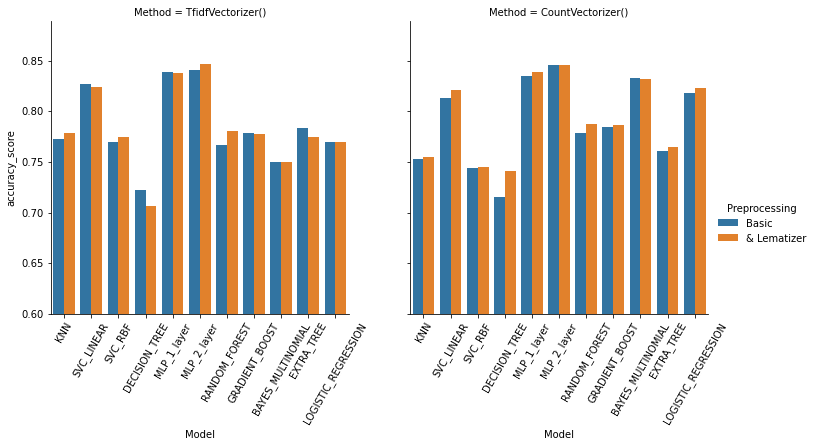

In [15]:
plot = sb.catplot(x='Model', y='accuracy_score', hue='Preprocessing', col='Method',data=dataframe, kind='bar')
plt.ylim(0.6)
for ax in plot.axes.flat:
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


### Advanced training

In [16]:
from models import Models
import random
from nlp_training import full_training

Selecting the top 3 classifiers. The multinomial bayes does not enter the list because it has no parameter variation.

In [17]:
models = {
    Models.MLP_2_layer.name: Models.MLP_2_layer.value,
    Models.SVC_LINEAR.name: Models.SVC_LINEAR.value,
    Models.LOGISTIC_REGRESSION.name: Models.LOGISTIC_REGRESSION.value,
}

In [18]:
C = [2 ** i for i in range(-5, 16,2)]
gamma = [2 ** i for i in range(-15, 4,2)]
gamma += ['auto','scale']

In [19]:
params = {
    Models.MLP_2_layer.name: {
        'clf__hidden_layer_sizes': [(random.randrange(0, 500), random.randrange(0, 500)) for i in range(1000)],
        'clf__tol':[0.001, 0.0005, 0.0001],
        'clf__learning_rate':['constant', 'invscaling','adaptive'],
        'clf__max_iter':[1000]
    },
    Models.SVC_LINEAR.name: {
        'clf__C':C,
    },
    Models.LOGISTIC_REGRESSION.name: {
        'clf__penalty':['l2', 'none'], 
        'clf__solver':['lbfgs','newton-cg','sag', 'saga'],
        'clf__max_iter':[10000]
    },
}

In [20]:
X_train, X_test = preprocessed_data[1][1], preprocessed_data[1][2]

In [21]:
dataframe = pd.DataFrame({})
for method in METHODS:
    aux = full_training(X_train, y_train, X_test, y_test, models, params, METRICS , method, n_iter=10)
    aux['Method'] = method
    dataframe = pd.concat([dataframe, aux], ignore_index=True)

/home/geovane/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/geovane/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [22]:
dataframe.sort_values(by=['accuracy_score'], ascending=[False]).head()

,Model,Params,accuracy_score,f1_score,precision_score,Method
2,LOGISTIC_REGRESSION,"{'clf__solver': 'lbfgs', 'clf__penalty': 'none...",0.848485,0.901186,0.875240,TfidfVectorizer()
0,MLP_2_layer,"{'clf__tol': 0.0005, 'clf__max_iter': 1000, 'c...",0.846970,0.899502,0.879377,TfidfVectorizer()
3,MLP_2_layer,"{'clf__tol': 0.0001, 'clf__max_iter': 1000, 'c...",0.843939,0.895643,0.891129,CountVectorizer()
1,SVC_LINEAR,{'clf__C': 2},0.839394,0.895874,0.865275,TfidfVectorizer()
5,LOGISTIC_REGRESSION,"{'clf__solver': 'sag', 'clf__penalty': 'l2', '...",0.837879,0.896016,0.856877,CountVectorizer()


(0.7, 0.890909090909091)

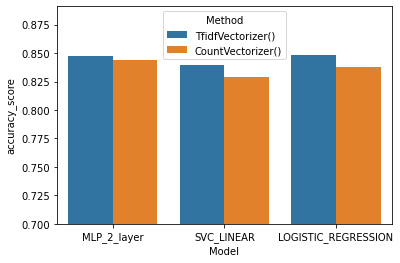

In [23]:
sb.barplot(y='accuracy_score', x = 'Model', hue='Method', data=dataframe)
plt.ylim(0.7)

### Final training

In [29]:
from nlp_training import final_training
from sklearn.metrics import accuracy_score
from random import randint
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
model = Models.MLP_2_layer.value
params = {
    'clf__hidden_layer_sizes':((randint(0, 500), randint(0, 500)), (randint(500, 1000),randint(500, 1000))),
    'clf__learning_rate':['constant', 'invscaling','adaptive'],
    'clf__max_iter':[1000],
    "vectorizer__max_df": (0.5, 1.0),
    "vectorizer__ngram_range": ((1, 1), (1, 2)),
}

In [33]:
dataframe = final_training(X_train, y_train, X_test, y_test, model, params, [accuracy_score], TfidfVectorizer())

In [34]:
dataframe

{'accuracy_score': 0.8469696969696969,
 'Params': Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                 ('clf',
                  MLPClassifier(hidden_layer_sizes=(275, 470),
                                learning_rate='adaptive', max_iter=1000))]),
 'Estimator': Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                 ('clf',
                  MLPClassifier(hidden_layer_sizes=(275, 470),
                                learning_rate='adaptive', max_iter=1000))])}